In [23]:
import dill 
import torch 
import torch.nn as nn
import numpy as np
from four_room.shortest_path import find_all_action_values
from four_room.env import FourRoomsEnv
from four_room.wrappers import gym_wrapper
import numpy as np
import dill
import gymnasium as gym
from four_room.utils import obs_to_state
from four_room.arch import CNN
from tqdm import tqdm
import matplotlib.pyplot as plt

### Setting up the datasets

In [30]:
gym.register('MiniGrid-FourRooms-v1', FourRoomsEnv)
size = 19
with open('configs/train.pl', 'rb') as file:
    train_config = dill.load(file)

with open('configs/test_unreachable.pl', 'rb') as file:
    test_config = dill.load(file)

with open('configs/validation_unreachable.pl', 'rb') as file:
    val_config = dill.load(file)

In [3]:
env = gym_wrapper(gym.make(
        'MiniGrid-FourRooms-v1', 
        agent_pos= train_config['agent positions'],
        goal_pos = train_config['goal positions'],
        doors_pos = train_config['topologies'],
        agent_dir = train_config['agent directions'],
        size=size
    ),
    original_obs=True
)

c:\Users\garga\Documents\Uni\four_room\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
c:\Users\garga\Documents\Uni\four_room\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(


In [4]:
class Dataset:
    
    def __init__(self):
        self.X = []
        self.Y = []
        self.states = []
        
    def add(self, x, y, state):
        self.X.append(x)
        self.Y.append(y)
        self.states.append(state)
        
        assert len(self.X) == len(self.Y)
    
    def __getitem__(self, index):
        return (self.X[index], self.Y[index])
    
    def __len__(self):
        return len(self.X)
    

In [5]:
argmax_dataset = Dataset()

for i in tqdm(range(len(train_config['topologies']))):
    obs, _ = env.reset()
    done = False
    while not done:
        state = obs_to_state(obs)
        q = find_all_action_values(state[:2], state[2], state[3:5], state[5:], 0.99, size)
        action = np.array(q).argmax()
        argmax_dataset.add(obs, q, state)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
with open('action_values/argmax_dataset.pl', 'wb') as file:
    dill.dump(argmax_dataset, file)

  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\garga\Documents\Uni\four_room\four_room\shortest_path.py:152: RuntimeWarning: overflow encountered in scalar subtract
  for p in nx.all_shortest_paths(graph, source=(*agent_pos, (agent_dir - 1)%4), target=(*goal_pos, dir)):
100%|██████████| 200/200 [00:54<00:00,  3.70it/s]


In [6]:
random_dataset = Dataset()

for i in tqdm(range(len(train_config['topologies']))):
    obs, _ = env.reset()
    done = False
    while not done:
        state = obs_to_state(obs)
        q = find_all_action_values(state[:2], state[2], state[3:5], state[5:], 0.99, size)
        action = env.action_space.sample()
        random_dataset.add(obs, q, state)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
with open('action_values/random_dataset.pl', 'wb') as file:
    dill.dump(random_dataset, file)

  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\garga\Documents\Uni\four_room\four_room\shortest_path.py:152: RuntimeWarning: overflow encountered in scalar subtract
  for p in nx.all_shortest_paths(graph, source=(*agent_pos, (agent_dir - 1)%4), target=(*goal_pos, dir)):
100%|██████████| 200/200 [05:38<00:00,  1.69s/it]


In [31]:
val_env = gym_wrapper(gym.make(
        'MiniGrid-FourRooms-v1', 
        agent_pos= val_config['agent positions'],
        goal_pos = val_config['goal positions'],
        doors_pos = val_config['topologies'],
        agent_dir = val_config['agent directions'],
        size=size
    ),
    original_obs=True
)

c:\Users\garga\Documents\Uni\four_room\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
c:\Users\garga\Documents\Uni\four_room\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(


In [33]:
val_argmax_dataset = Dataset()

for i in tqdm(range(len(val_config['topologies']))):
    obs, _ = val_env.reset()
    done = False
    while not done:
        state = obs_to_state(obs)
        q = find_all_action_values(state[:2], state[2], state[3:5], state[5:], 0.99, size)
        action = np.array(q).argmax()
        val_argmax_dataset.add(obs, q, state)
        obs, reward, terminated, truncated, info = val_env.step(action)
        done = terminated or truncated

  0%|          | 0/40 [00:00<?, ?it/s]c:\Users\garga\Documents\Uni\four_room\four_room\shortest_path.py:152: RuntimeWarning: overflow encountered in scalar subtract
  for p in nx.all_shortest_paths(graph, source=(*agent_pos, (agent_dir - 1)%4), target=(*goal_pos, dir)):
100%|██████████| 40/40 [00:11<00:00,  3.49it/s]


### Regression

In [50]:
class RegressionModel(nn.Module):
    
    def __init__(
        self, 
        obsservation_space, 
        action_space, 
        feature_dim: int = 64, 
        hidden_layers: list = list([256]), 
        activation: nn.Module = nn.ReLU,
        lr: float = 1e-3, 
        *args, 
        **kwargs
    ):
        super(RegressionModel, self).__init__(*args, **kwargs)
        
        self.feature_extractor = CNN(obsservation_space, feature_dim)
        self.layers = nn.Sequential(
            nn.Linear(feature_dim, hidden_layers[0])
        )
        
        # add more layers after the feature extractor
        for i, layer in enumerate(hidden_layers[:-1]):
            self.layers.append(
                nn.Linear(layer, hidden_layers[i+1]),
                activation()
            )
            
        # final layer for predicting values
        self.layers.append(
            nn.Linear(hidden_layers[-1], action_space.n)
        )
        
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    
        
    def forward(self, obs):
        x = self.feature_extractor(obs)
        x = self.layers(x)
        return x 
    
    def train(
        self, 
        dataset: Dataset, 
        val_dataset: Dataset, 
        timesteps: int = 100, 
        batch_size: int = 64, 
    ): 
        X_train = torch.as_tensor(np.array(dataset.X), dtype=torch.float32)
        y_train = torch.as_tensor(np.array(dataset.Y), dtype=torch.float32)
        
        X_eval = torch.as_tensor(np.array(val_dataset.X), dtype=torch.float32)
        y_eval = torch.as_tensor(np.array(val_dataset.Y), dtype=torch.float32)
        
        train_losses = []
        val_losses = []
        for step in range(timesteps+1):
            batch_idx = torch.randint(low=0, high=len(dataset)-1, size=(batch_size,))
            batch_x = X_train[batch_idx]
            batch_y = y_train[batch_idx]
            
            preds = self(batch_x)
            loss = self.loss(preds, batch_y)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_losses.append(loss.item())
            with torch.no_grad():
                val_preds = self(X_eval)
                val_loss = self.loss(val_preds, y_eval)
                val_losses.append(val_loss.item())
                
            print(f'Step: {step} | Loss: {loss.item():.3f} | Val Loss: {val_loss.item():.3f}', end='\r')
            
        return train_losses, val_losses

In [51]:
model = RegressionModel(env.observation_space, env.action_space)
train_losses, val_losses = model.train(argmax_dataset, val_argmax_dataset)

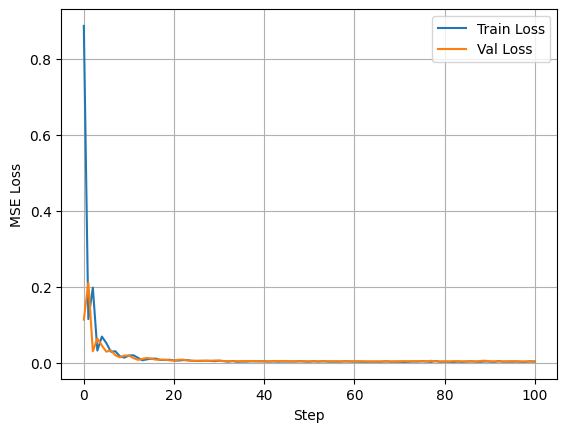

In [53]:
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
plt.plot(np.arange(len(val_losses)), val_losses, label='Val Loss')
plt.xlabel('Step')
plt.ylabel('MSE Loss')
plt.grid()
plt.legend();